In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics

def get_num_par(model_id):
    if model_id == 'last1':
        return 1
    if model_id in ['pow2', 'log2', 'exp2', 'lin2', 'ilog2']:
        return 2
    if model_id in ['pow3', 'exp3', 'vap3', 'expp3', 'expd3', 'logpower3']:
        return 3
    if model_id in ['mmf4', 'wbl4', 'exp4', 'pow4']:
        return 4

def get_fun_model_id(beta,model_id):
    num_par = get_num_par(model_id)
    fun = None

    # unpack parameters
    if num_par == 1:
        a = beta[0]
    if num_par == 2:
        a, b = beta[0], beta[1]
    if num_par == 3:
        a, b, c = beta[0], beta[1], beta[2]
    if num_par == 4:
        a, b, c, d = beta[0], beta[1], beta[2], beta[3]

    # define curve models
    if model_id == 'pow2':
        fun = lambda x: -a * x ** (-b)
    if model_id == 'pow3':
        fun = lambda x: a - b * x ** (-c)
    if model_id == 'log2':
        fun = lambda x: -a * np.log(x) + b
    if model_id == 'exp3':
        fun = lambda x: a * np.exp(-b * x) + c
    if model_id == 'exp2':
        fun = lambda x: a * np.exp(-b * x)
    if model_id == 'lin2':
        fun = lambda x: a * x + b
    if model_id == 'vap3':
        fun = lambda x: np.exp(a + b / x + c * np.log(x))
    if model_id == 'mmf4':
        fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    if model_id == 'wbl4':
        fun = lambda x: (c - b * np.exp(-a * (x ** d)))
    if model_id == 'exp4':
        fun = lambda x: c - np.exp(-a * (x ** d) + b)
    if model_id == 'expp3':
        # fun = lambda x: a * np.exp(-b*x) + c
        fun = lambda x: c - np.exp((x - b) ** a)
    if model_id == 'pow4':
        fun = lambda x: a - b * (x + d) ** (-c)  # has to closely match pow3
    if model_id == 'ilog2':
        fun = lambda x: b - (a / np.log(x))
    if model_id == 'expd3':
        fun = lambda x: c - (c - a) * np.exp(-b * x)
    if model_id == 'logpower3':
        fun = lambda x: a / (1 + (x / np.exp(b)) ** c)
    if model_id == 'last1':
        fun = lambda x: (a + x) - x  # casts the prediction to have the correct size
    return fun

def df_compute_metrics_mean_curve(df,df_info):
    pbar = tqdm(total=len(df))
    rows_metrics = []
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        anchor_prediction, score = get_info_mean_curve(df_info, row.openmlid, row.learner)
        rows_metrics.append(metrics_per_row(row,score,anchor_prediction))
        pbar.update(1)
    pbar.close()
    df_metrics = pd.DataFrame(rows_metrics,columns=['MSE trn','MSE tst','MSE tst last','L1 trn','L1 tst','L1 tst last','max anchor seen','percentage','n','curve_model'])
    return df_metrics

def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

def metrics_per_row(row, score, anchor_prediction):
    
    max_anchor_seen = row.max_anchor_seen
    prediction = row.prediction
    max_anchor = np.max(anchor_prediction)
    percentage_train = np.round(max_anchor_seen/max_anchor*100)/100

    trn_ind = np.argwhere(max_anchor_seen == anchor_prediction)[0][0] # recover offset
    trn_indices = range(0,(trn_ind+1))
    tst_indices = range(trn_ind+1,len(anchor_prediction))
    n_trn = len(trn_indices)
    
    y_trn_hat = prediction[trn_indices]
    y_trn = score[trn_indices]
    y_tst_hat = prediction[tst_indices]
    y_tst = score[tst_indices]

    MSE_trn = np.mean((y_trn - y_trn_hat)**2)
    MSE_tst = np.mean((y_tst - y_tst_hat)**2)
    MSE_tst_last = (y_tst[-1] -  y_tst_hat[-1])**2
    L1_trn = np.mean((y_trn -y_trn_hat)**2)
    L1_tst = np.mean((y_tst - y_tst_hat)**2)
    L1_tst_last = (y_tst[-1] - y_tst_hat[-1])**2
    
    return [MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max_anchor_seen,percentage_train,n_trn,row.curve_model]

def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [427]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

#matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=5, highv=15,
                width=100, textspace=1, reverse=True, filename=None, labels=False, dpi=10, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height),dpi=dpi)
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 0.5
    linewidth_sign = 2.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = 0
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    #print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        #print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign,color='r')
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=30, textspace=3, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.pdf',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    #print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    #print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

#df_perf = pd.read_csv('DefaultvsTunedvsEnsembleCritDiffAcc.csv',index_col=False)

#draw_cd_diagram(df_perf=df_perf, title='Accuracy', labels=True)

# Cleaning the data and processing

In [2]:
from os.path import exists
df = pd.read_csv('lcdb_new.csv')
if exists('lcdb_new_anchors_scores.p'):
    df_anchors_and_scores = pd.read_pickle('lcdb_new_anchors_scores.p')
else:
    df_anchors_and_scores = get_anchors_and_scores_mean_curve(df)

    df_anchors_and_scores.to_pickle('lcdb_new_anchors_scores.p')

In [3]:
df_metrics_list = []
df_extrapolations_list = []
for i in range(0,10):
    df_metrics_list.append(pd.read_pickle('metrics%d.p' % i))
    df_extrapolations_list.append(pd.read_pickle('extrapolations%d.p' % i))
    
df_metrics = pd.concat(df_metrics_list,axis=0)
df_extrapolations = pd.concat(df_extrapolations_list,axis=0)
assert(len(df_metrics) == len(df_extrapolations))

In [4]:
df_metrics

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,2.754000e-08,0.009277,0.030276,2.754000e-08,0.009277,0.030276,45,0.01,4,pow4
1,1.009901e-06,0.000414,0.000630,1.009901e-06,0.000414,0.000630,64,0.01,5,pow4
2,8.378000e-07,0.000452,0.000635,8.378000e-07,0.000452,0.000635,91,0.01,6,pow4
3,1.860855e-06,0.000071,0.000085,1.860855e-06,0.000071,0.000085,128,0.02,7,pow4
4,1.765756e-06,0.000015,0.000006,1.765756e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...
67467,4.666109e-05,0.000149,0.000166,4.666109e-05,0.000149,0.000166,8192,0.14,19,logpower3
67468,4.839265e-05,0.000099,0.000096,4.839265e-05,0.000099,0.000096,11585,0.20,20,logpower3
67469,4.985381e-05,0.000056,0.000050,4.985381e-05,0.000056,0.000050,16384,0.28,21,logpower3
67470,4.925426e-05,0.000040,0.000030,4.925426e-05,0.000040,0.000030,23170,0.40,22,logpower3


In [5]:
df_extrapolations

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta,fails_init,fails_fit
0,24,SVC_linear,45,"[0.8882, 0.9129, 0.9325, 0.9511, 0.9691, 0.986...",pow4,"[3.4418299555164094, 2.6634082053587433, 0.018...",0,0
1,24,SVC_linear,64,"[0.888, 0.9133, 0.9333, 0.9494, 0.9609, 0.9678...",pow4,"[0.9749338390233945, 19434.87738296287, 3.0299...",0,0
2,24,SVC_linear,91,"[0.888, 0.9132, 0.9332, 0.9494, 0.961, 0.9679,...",pow4,"[0.9748273144231531, 41404.69654147434, 3.1754...",0,0
3,24,SVC_linear,128,"[0.8879, 0.9137, 0.9329, 0.9486, 0.9609, 0.969...",pow4,"[0.9910112534284682, 3.4028442598555797, 1.106...",0,0
4,24,SVC_linear,181,"[0.8879, 0.914, 0.9329, 0.9483, 0.9606, 0.97, ...",pow4,"[0.9982729629370699, 1.286412335833199, 0.8414...",0,0
...,...,...,...,...,...,...,...,...
67467,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5223, 0.5292, 0.5355, 0.5422, 0.5492, 0.556...",logpower3,"[111.04586681713516, 149.78329428384959, -0.03...",0,0
67468,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.5214, 0.5284, 0.5349, 0.5417, 0.5488, 0.556...",logpower3,"[123.48194245357753, 149.82332291283996, -0.03...",0,0
67469,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205, 0.5277, 0.5343, 0.5412, 0.5484, 0.555...",logpower3,"[139.59677340890977, 150.61883973956628, -0.03...",0,0
67470,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.52, 0.5272, 0.5339, 0.5409, 0.5482, 0.5556,...",logpower3,"[150.25605535211247, 151.0608671642381, -0.038...",0,0


In [6]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics],axis=1)
df_total = df_total.rename(columns={'MSE trn':'MSE_trn','MSE tst':'MSE_tst','MSE tst last': 'MSE_tst_last', 'L1 trn':'L1_trn', 'L1 tst':'L1_tst', 'L1 tst last':'L1_tst_last'})

In [7]:
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,24,SVC_linear,45,"[0.8882, 0.9129, 0.9325, 0.9511, 0.9691, 0.986...","[3.4418299555164094, 2.6634082053587433, 0.018...",0,0,2.754000e-08,0.009277,0.030276,2.754000e-08,0.009277,0.030276,45,0.01,4,pow4
1,24,SVC_linear,64,"[0.888, 0.9133, 0.9333, 0.9494, 0.9609, 0.9678...","[0.9749338390233945, 19434.87738296287, 3.0299...",0,0,1.009901e-06,0.000414,0.000630,1.009901e-06,0.000414,0.000630,64,0.01,5,pow4
2,24,SVC_linear,91,"[0.888, 0.9132, 0.9332, 0.9494, 0.961, 0.9679,...","[0.9748273144231531, 41404.69654147434, 3.1754...",0,0,8.378000e-07,0.000452,0.000635,8.378000e-07,0.000452,0.000635,91,0.01,6,pow4
3,24,SVC_linear,128,"[0.8879, 0.9137, 0.9329, 0.9486, 0.9609, 0.969...","[0.9910112534284682, 3.4028442598555797, 1.106...",0,0,1.860855e-06,0.000071,0.000085,1.860855e-06,0.000071,0.000085,128,0.02,7,pow4
4,24,SVC_linear,181,"[0.8879, 0.914, 0.9329, 0.9483, 0.9606, 0.97, ...","[0.9982729629370699, 1.286412335833199, 0.8414...",0,0,1.765756e-06,0.000015,0.000006,1.765756e-06,0.000015,0.000006,181,0.03,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67467,40668,sklearn.tree.ExtraTreeClassifier,8192,"[0.5223, 0.5292, 0.5355, 0.5422, 0.5492, 0.556...","[111.04586681713516, 149.78329428384959, -0.03...",0,0,4.666109e-05,0.000149,0.000166,4.666109e-05,0.000149,0.000166,8192,0.14,19,logpower3
67468,40668,sklearn.tree.ExtraTreeClassifier,11585,"[0.5214, 0.5284, 0.5349, 0.5417, 0.5488, 0.556...","[123.48194245357753, 149.82332291283996, -0.03...",0,0,4.839265e-05,0.000099,0.000096,4.839265e-05,0.000099,0.000096,11585,0.20,20,logpower3
67469,40668,sklearn.tree.ExtraTreeClassifier,16384,"[0.5205, 0.5277, 0.5343, 0.5412, 0.5484, 0.555...","[139.59677340890977, 150.61883973956628, -0.03...",0,0,4.985381e-05,0.000056,0.000050,4.985381e-05,0.000056,0.000050,16384,0.28,21,logpower3
67470,40668,sklearn.tree.ExtraTreeClassifier,23170,"[0.52, 0.5272, 0.5339, 0.5409, 0.5482, 0.5556,...","[150.25605535211247, 151.0608671642381, -0.038...",0,0,4.925426e-05,0.000040,0.000030,4.925426e-05,0.000040,0.000030,23170,0.40,22,logpower3


# Remove fits that failed repeatedly

In [8]:
def remove_fails(df_total):

    fail_init = df_total['fails_init'] > 1000
    fail_fit = df_total['fails_fit'] > 100

    print('fail due to init %d' % fail_init.sum())
    print('fail due to fit %d' % fail_fit.sum())

    fail_ind = pd.concat([fail_init,fail_fit],axis=1)
    fail_ind = fail_ind.any(axis=1)
    print('fail total %d' % sum(fail_ind))

    df_fail = df_total[fail_ind]
    df_total_new = df_total[fail_ind == False]
    
    return [df_total_new,df_fail]

[df_total_no_fail,df_fail] = remove_fails(df_total)
assert(len(df_total_no_fail) + len(df_fail) == len(df_total))

fail due to init 0
fail due to fit 186
fail total 186


In [9]:
assert((df_total_no_fail['fails_fit'] > 100).sum() == 0) # check that indeed we got rid of them

# Remove rows with nan or inf in the numerical columns

In [10]:
def remove_nan_and_inf(df_total):

    numeric = df_total.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]
    #numeric.describe()

    ind_nan_or_inf = numeric.isin([np.inf, -np.inf, np.nan]).any(axis=1)
    print('number of rows with nans / infs:',ind_nan_or_inf.sum())
    print('columns with nans / infs:')
    print(numeric.isin([np.inf, -np.inf, np.nan]).any())
    
    return df_total[ind_nan_or_inf == False], df_total[ind_nan_or_inf == True]

df_no_fail_no_nan_or_inf, df_nan_or_inf = remove_nan_and_inf(df_total_no_fail)
assert(len(df_no_fail_no_nan_or_inf) + len(df_nan_or_inf) == len(df_total_no_fail))

number of rows with nans / infs: 240
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
L1_trn             False
L1_tst              True
L1_tst_last         True
max anchor seen    False
percentage         False
n                  False
curve_model        False
dtype: bool


In [11]:
numeric = df_no_fail_no_nan_or_inf.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]
numeric = numeric.isin([np.inf, -np.inf, np.nan]).any(axis=1)
assert(numeric.sum() == 0)


# Remove rows whose MSE or L1 performance is larger than 100

In [12]:

def remove_performace_too_bad(df_total):
    
    numeric = df_total.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]

    threshold = 100

    error_MSE_trn = numeric['MSE_trn'] > threshold
    error_MSE_tst = numeric['MSE_tst'] > threshold
    error_MSE_tst_last = numeric['MSE_tst_last'] > threshold
    error_L1_trn = numeric['L1_trn'] > threshold
    error_L1_tst = numeric['L1_tst'] > threshold
    error_L1_tst_last = numeric['L1_tst_last'] > threshold

    errors_fit = pd.concat([error_MSE_trn,error_MSE_tst,error_MSE_tst_last,error_L1_trn,error_L1_tst,error_L1_tst_last],axis=1)
    print('performance too bad for analysis:')
    print(errors_fit.sum())
    print('number of offending rows:')
    print(errors_fit.any(axis=1).sum())

    errors_ind = errors_fit.any(axis=1)
    return df_total[errors_ind == False], df_total[errors_ind == True]

df_no_fail_no_nan_or_inf_no_too_bad, df_too_bad = remove_performace_too_bad(df_no_fail_no_nan_or_inf)
assert(len(df_no_fail_no_nan_or_inf_no_too_bad) + len(df_too_bad) == len(df_no_fail_no_nan_or_inf))

performance too bad for analysis:
MSE_trn            89
MSE_tst         16218
MSE_tst_last    21237
L1_trn             89
L1_tst          16218
L1_tst_last     21237
dtype: int64
number of offending rows:
21248


In [13]:
numeric = df_no_fail_no_nan_or_inf_no_too_bad.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]]
threshold = 100

error_MSE_trn = numeric['MSE_trn'] > threshold
error_MSE_tst = numeric['MSE_tst'] > threshold
error_MSE_tst_last = numeric['MSE_tst_last'] > threshold
error_L1_trn = numeric['L1_trn'] > threshold
error_L1_tst = numeric['L1_tst'] > threshold
error_L1_tst_last = numeric['L1_tst_last'] > threshold

errors_fit = pd.concat([error_MSE_trn,error_MSE_tst,error_MSE_tst_last,error_L1_trn,error_L1_tst,error_L1_tst_last],axis=1)
errors_ind = errors_fit.any(axis=1)
assert(errors_ind.sum() == 0)

In [28]:
df_nan_or_inf

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
12048,554,SVC_linear,45,"[0.4627, 0.4958, 0.5419, 0.6161, 0.7432, 0.970...","[0.3950298830495756, -0.009876001554637028]",0,0,0.000242,inf,inf,0.000242,inf,inf,45,0.0,4,exp2
12049,554,SVC_linear,64,"[0.4761, 0.5011, 0.5352, 0.5885, 0.6762, 0.823...","[0.42352454100736997, -0.007310613346442617]",0,0,0.000450,inf,inf,0.000450,inf,inf,64,0.0,5,exp2
12371,554,SVC_rbf,128,"[0.307, 0.3263, 0.353, 0.3953, 0.4665, 0.5903,...","[0.26706199044344703, -0.008716488602950375]",0,0,0.008503,inf,inf,0.008503,inf,inf,128,0.0,7,exp2
12691,554,SVC_sigmoid,128,"[0.2311, 0.2489, 0.2738, 0.3142, 0.3841, 0.511...","[0.19513787200304608, -0.010582250653331208]",0,0,0.008108,inf,inf,0.008108,inf,inf,128,0.0,7,exp2
12692,554,SVC_sigmoid,181,"[0.2766, 0.2898, 0.3077, 0.3354, 0.3806, 0.455...","[0.24867522359816055, -0.0066511097859660384]",0,0,0.013731,inf,inf,0.013731,inf,inf,181,0.0,8,exp2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54484,1483,sklearn.tree.DecisionTreeClassifier,181,"[0.2723, 0.2768, 0.2826, 0.2914, 0.3046, 0.324...","[0.2622499200377136, -0.0023404093967881604]",0,0,0.000282,inf,inf,0.000282,inf,inf,181,0.0,8,exp2
54864,1483,sklearn.tree.ExtraTreeClassifier,45,"[0.2141, 0.2196, 0.2269, 0.2379, 0.255, 0.2813...","[0.20201526485007348, -0.003636897308234812]",0,0,0.000062,inf,inf,0.000062,inf,inf,45,0.0,4,exp2
54865,1483,sklearn.tree.ExtraTreeClassifier,64,"[0.2126, 0.2191, 0.2278, 0.2409, 0.2614, 0.293...","[0.19846485616639278, -0.004305021831271053]",0,0,0.000053,inf,inf,0.000053,inf,inf,64,0.0,5,exp2
54866,1483,sklearn.tree.ExtraTreeClassifier,91,"[0.2167, 0.2215, 0.2279, 0.2374, 0.252, 0.2743...","[0.20606624571648668, -0.0031439282648436984]",0,0,0.000071,inf,inf,0.000071,inf,inf,91,0.0,6,exp2


In [29]:

reason = ['fail']*len(df_fail)
df_fail2 = df_fail.copy()
df_fail2.insert(0, 'reason', reason)
reason = ['nan_or_inf'] * len(df_nan_or_inf)
df_nan_or_inf2 = df_nan_or_inf.copy()
df_nan_or_inf2.insert(0, 'reason', reason)
reason = ['too_bad'] * len(df_too_bad)
df_too_bad2 = df_too_bad.copy()
df_too_bad2.insert(0, 'reason', reason)

In [30]:
df_too_bad

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
56,24,SVC_linear,45,"[0.8941, 0.9084, 0.9272, 0.9549, 0.997, 1.06, ...","[0.8622562829491435, -0.0022687731036038156]",0,0,0.000024,4.897034e+11,6.855760e+12,0.000024,4.897034e+11,6.855760e+12,45,0.01,4,exp2
57,24,SVC_linear,64,"[0.9008, 0.9105, 0.923, 0.9414, 0.969, 1.0096,...","[0.8791643558239207, -0.0015205561431177338]",0,0,0.000085,2.907520e+07,3.777745e+08,0.000085,2.907520e+07,3.777745e+08,64,0.01,5,exp2
58,24,SVC_linear,91,"[0.9077, 0.9142, 0.9226, 0.935, 0.9533, 0.98, ...","[0.8929239202253929, -0.0010226519505714905]",0,0,0.000154,4.656199e+04,5.550780e+05,0.000154,4.656199e+04,5.550780e+05,91,0.01,6,exp2
59,24,SVC_linear,128,"[0.9136, 0.9183, 0.9242, 0.933, 0.9459, 0.9645...","[0.9031173715513677, -0.0007227660392105753]",0,0,0.000208,1.011047e+03,1.079887e+04,0.000208,1.011047e+03,1.079887e+04,128,0.02,7,exp2
60,24,SVC_linear,181,"[0.9198, 0.9231, 0.9272, 0.9333, 0.9422, 0.955...","[0.91247975597632, -0.0005015241442091951]",0,0,0.000277,6.124638e+01,5.630180e+02,0.000277,6.124638e+01,5.630180e+02,181,0.03,8,exp2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67273,40668,sklearn.tree.ExtraTreeClassifier,64,"[0.5338, 0.5354, 0.5374, 0.5404, 0.5448, 0.551...","[0.00022903172735075765, 0.5301196578153755]",0,0,0.000104,1.442963e+01,1.689221e+02,0.000104,1.442963e+01,1.689221e+02,64,0.00,5,lin2
67274,40668,sklearn.tree.ExtraTreeClassifier,91,"[0.532, 0.5344, 0.5376, 0.5422, 0.5488, 0.5583...","[0.0003507179742261226, 0.5263805714974537]",0,0,0.000092,3.623945e+01,3.998882e+02,0.000092,3.623945e+01,3.998882e+02,91,0.00,6,lin2
67275,40668,sklearn.tree.ExtraTreeClassifier,128,"[0.5341, 0.5359, 0.5381, 0.5414, 0.5461, 0.552...","[0.0002488989020864474, 0.5301659054382237]",0,0,0.000089,1.911348e+01,1.999539e+02,0.000089,1.911348e+01,1.999539e+02,128,0.00,7,lin2
67276,40668,sklearn.tree.ExtraTreeClassifier,181,"[0.5354, 0.5369, 0.5387, 0.5414, 0.5453, 0.550...","[0.0002061776350779635, 0.5321161214568475]",0,0,0.000081,1.382694e+01,1.365066e+02,0.000081,1.382694e+01,1.365066e+02,181,0.00,8,lin2


In [31]:
df_removed = pd.concat([df_fail2,df_nan_or_inf2,df_too_bad2],axis=0)
df_clean = df_no_fail_no_nan_or_inf_no_too_bad
df_clean.describe()

,openmlid,max_anchor_seen,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,622806.000000,6.228060e+05,622806.000000,622806.00000,622806.000000,622806.000000,622806.000000,622806.000000,622806.000000,622806.000000,6.228060e+05,622806.000000,622806.000000
mean,2438.503862,5.764779e+03,0.172253,0.08699,0.010007,0.157934,0.723353,0.010007,0.157934,0.723353,5.764779e+03,0.194472,10.818952
std,7222.928475,3.488012e+04,1.150108,0.74705,0.282917,1.239193,5.542310,0.282917,1.239193,5.542310,3.488012e+04,0.221058,5.295462
min,3.000000,4.500000e+01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000e+01,0.000000,4.000000
25%,395.000000,1.280000e+02,0.000000,0.00000,0.000010,0.000073,0.000082,0.000010,0.000073,0.000082,1.280000e+02,0.030000,7.000000
50%,881.000000,3.620000e+02,0.000000,0.00000,0.000047,0.000727,0.001151,0.000047,0.000727,0.001151,3.620000e+02,0.100000,10.000000
75%,1130.000000,1.448000e+03,0.000000,0.00000,0.000266,0.006342,0.012821,0.000266,0.006342,0.012821,1.448000e+03,0.300000,14.000000
max,40672.000000,1.048576e+06,134.000000,99.00000,34.838170,96.368234,99.947047,34.838170,96.368234,99.947047,1.048576e+06,1.000000,33.000000


# Statistics for failed fits

In [32]:
my_series = df_total['fails_fit'].value_counts().sort_index()

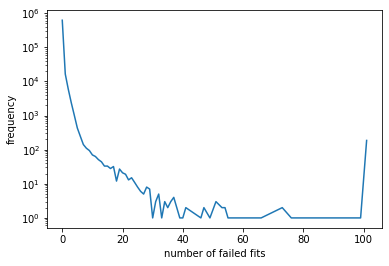

In [33]:
X = my_series.index
Y = my_series.values
plt.figure()
plt.plot(X,Y)
plt.yscale('log')
plt.xlabel('number of failed fits')
plt.ylabel('frequency')
plt.show()

In [34]:
df_removed['reason'].value_counts()

too_bad       21248
nan_or_inf      240
fail            186
Name: reason, dtype: int64

In [51]:
rows = []
for [curve_model, df_removed_curve] in df_removed.groupby('curve_model'):
    too_bad = (df_removed_curve['reason'] == 'too_bad').sum()
    nan_or_inf = (df_removed_curve['reason'] == 'nan_or_inf').sum()
    fail = (df_removed_curve['reason'] == 'fail').sum()
    total = len(df_removed_curve)
    rows.append([curve_model,fail,nan_or_inf,too_bad,total])
a = pd.DataFrame(rows,columns=['curve model','fail','nan or inf','too bad','total'])
row_total = a.iloc[:,[1,2,3,4]].sum()
total = list(row_total)
rows.append(['all',total[0],total[1],total[2],total[3]])
a = pd.DataFrame(rows,columns=['curve model','fail','nan or inf','too bad','total'])
a

,curve model,fail,nan or inf,too bad,total
0,exp2,184,206,12191,12581
1,exp3,0,16,364,380
2,exp4,0,2,256,258
3,expd3,0,12,431,443
4,expp3,2,0,198,200
5,lin2,0,0,4912,4912
6,logpower3,0,0,6,6
7,mmf4,0,0,179,179
8,pow2,0,0,29,29
9,pow3,0,0,466,466


# Statistical tests

In [428]:
curve_models = df_total['curve_model'].unique()

rows = []
info_rows = []
tqdm
for (openmlid, df_dataset) in tqdm(df_clean[0:100000].groupby('openmlid')):
    for (learner, df_learner) in df_dataset.groupby('learner'):
        for (n, df_n) in df_learner.groupby('n'):
            new_row = []
            info_rows.append([openmlid,learner,n])
            for curve_model in curve_models:
                row = df_n.query('curve_model == @curve_model')
                score = np.nan
                if len(row) > 0:
                    row = row.iloc[0,:]
                    score = row.MSE_tst_last
                new_row.append(score)
            rows.append(new_row)


  0%|          | 0/35 [00:00<?, ?it/s]

In [441]:
a = np.array(rows)
#a = np.log(a)
a = pd.DataFrame(a,columns=curve_models)
a_info = np.array(info_rows)
a_info = pd.DataFrame(a_info,columns=['openmlid','learner','n'])
b = pd.concat([a_info,a],axis=1)


In [442]:
def remove_rows_with_nan_or_inf(c):
    c = c.copy()
    ind_nan_or_inf = c.isin([np.inf, -np.inf, np.nan]).any(axis=1)
    c = c[ind_nan_or_inf == False]
    return c

In [443]:
c = remove_rows_with_nan_or_inf(b)

melted = pd.melt(c,id_vars=['openmlid','learner','n'],value_vars=curve_models)
dataset_name = melted.agg('{0[openmlid]},{0[learner]},{0[n]}'.format, axis=1)
melted['dataset_name'] = dataset_name


In [444]:
df_cd = melted[['variable','dataset_name','value']]
df_cd = df_cd.rename(columns={'variable': 'classifier_name', 'value': 'accuracy'})

df_cd['accuracy'] = -df_cd['accuracy']

df_cd

,classifier_name,dataset_name,accuracy
0,pow4,"12,SVC_linear,9",-0.000212
1,pow4,"12,SVC_linear,10",-0.000051
2,pow4,"12,SVC_linear,11",-0.000040
3,pow4,"12,SVC_linear,12",-0.000025
4,pow4,"12,SVC_linear,13",-0.000011
...,...,...,...
67435,logpower3,"4541,sklearn.tree.ExtraTreeClassifier,21",-0.000017
67436,logpower3,"4541,sklearn.tree.ExtraTreeClassifier,22",-0.000013
67437,logpower3,"4541,sklearn.tree.ExtraTreeClassifier,23",-0.000010
67438,logpower3,"4541,sklearn.tree.ExtraTreeClassifier,24",-0.000008


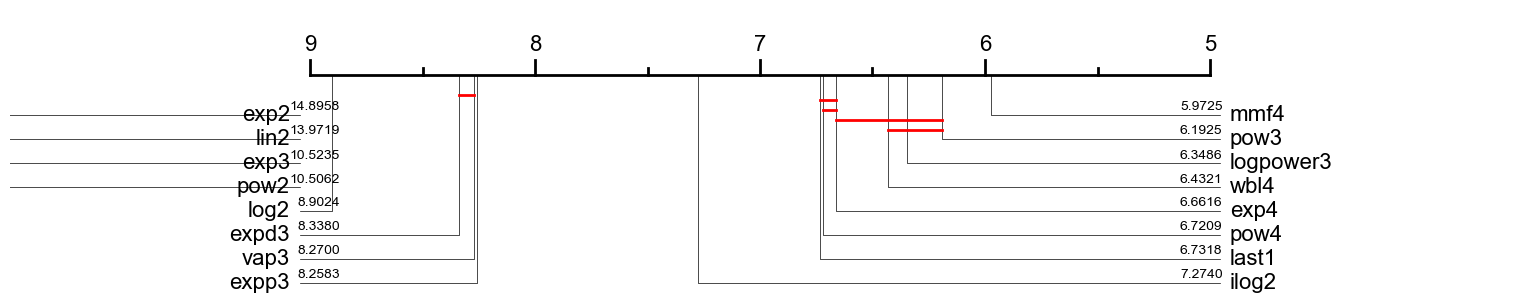

In [445]:
%matplotlib inline

p_values, average_ranks, _ = wilcoxon_holm(df_perf=bla, alpha=0.05)

graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
            cd=None, reverse=True, width=15, textspace=3, labels=True, dpi=100,lowv=5,highv=9)

font = {'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 22,
    }
plt.show()

In [160]:
curve_models
curve_model = 'pow4'

In [166]:
row.MSE_tst

0.0016941455999999978

# Visualize a learning curve

In [ ]:
def get_XY(row):
    learner = row.learner
    openmlid = row.openmlid
    [X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)
    return [X, Y]


In [ ]:
def set_ylim(row, margin=0.05):
    
    [X, Y] = get_XY(row)
    Y_diff = np.max(Y) - np.min(Y)
    plt.ylim([np.min(Y),np.max(Y)])
    #plt.ylim([np.min(Y) - Y_diff*margin,np.max(Y) + Y_diff*margin])


def plot_data(row):
    
    [X, Y] = get_XY(row)

    plt.plot(X,Y,'*b')
    set_ylim(row)
    plt.xlabel('anchors')
    plt.ylabel('accuracy')
    
    learner = row.learner
    openmlid = row.openmlid
    plt.title('%s dataset %d' % (learner, openmlid))

def plot_trn_data(row):
    
    [X, Y] = get_XY(row)
    
    offset = np.argwhere(X == row.max_anchor_seen)[0][0]

    X_trn = X[:offset+1]
    Y_trn = Y[:offset+1]
    
    plt.plot(X_trn,Y_trn,'*r')
    set_ylim(row)
    plt.xlabel('anchors')
    plt.ylabel('accuracy')
    
    learner = row.learner
    openmlid = row.openmlid
    plt.title('%s dataset %d' % (learner, openmlid))
    
def plot_prediction(row):
    
    curve_model = row.curve_model
    [X, Y] = get_XY(row)
    
    plt.plot(X,row.prediction,':',label=curve_model)
    plt.legend()
    
def plot_prediction_smooth(row):
    
    curve_model = row.curve_model
    
    [X, Y] = get_XY(row)
    
    fun = get_fun_model_id(row.beta,curve_model)
    
    X_plot = np.arange(np.min(X),np.max(X))
    Y_hat = fun(X_plot)
    
    plt.plot(X_plot,Y_hat,'-',label=curve_model)
    plt.legend()



In [ ]:
row = df_removed.sample()
#row = df_no_fail_no_nan_or_inf_no_too_bad.sample()
row = row.iloc[0,:]

plt.figure(figsize=(8,8))
plot_data(row)
plot_trn_data(row)
plot_prediction(row)
plot_prediction_smooth(row)
plt.show()

Text(0, 0.5, 'log')

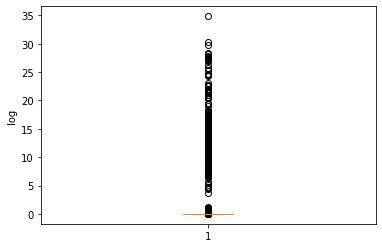

In [57]:
plt.boxplot(df_clean['MSE_trn'])
plt.ylabel('log')

In [ ]:
df_removed['n'].value_counts()

# Distribution of MSEs

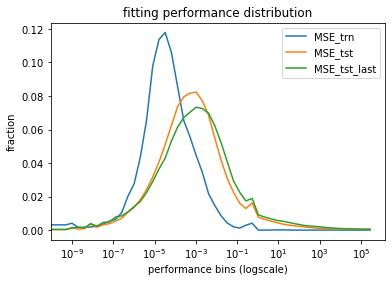

In [136]:
def plot_metric(series,my_metric,ls='-'):
    curbin = 0.0000000005
    binlist = [0]
    while curbin < 1000000:
        binlist.append(curbin)
        curbin *= 2
    [hist,edges] = np.histogram(series,bins=binlist)
    plt.plot(edges[:-1],hist/np.sum(hist),ls,label=my_metric)
    plt.xscale('log')

plt.figure()    

plot_metric(df_total['MSE_trn'],'MSE_trn')
plot_metric(df_total['MSE_tst'],'MSE_tst')
plot_metric(df_total['MSE_tst_last'],'MSE_tst_last')

plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance distribution')
plt.show()

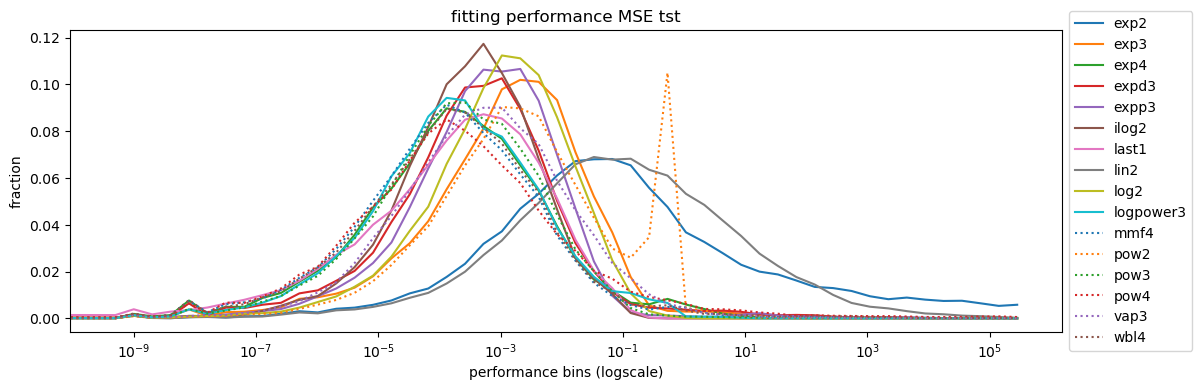

In [143]:
plt.figure(figsize=(16,4),dpi=100)
ax = plt.subplot(111)

i = 0
for [curve_model, df_curve_model] in df_total.groupby('curve_model'):
    ls = '-'
    if i > 9:
        ls = ':'
    plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance MSE tst')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

KeyError: 'fraction'

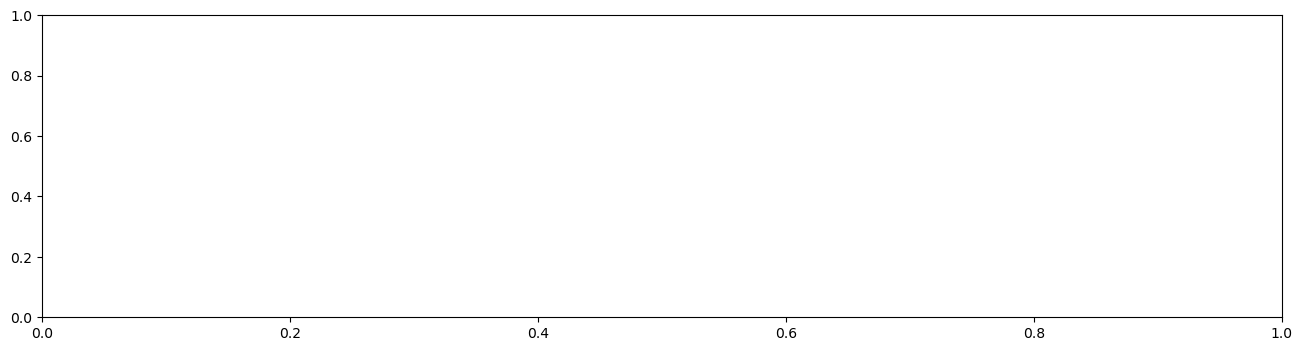

In [147]:
plt.figure(figsize=(16,4),dpi=100)
ax = plt.subplot(111)

i = 0
for [n, df_n] in df_total.groupby('fraction'):
    ls = '-'
    plot_metric(df_n['MSE_tst'],str(n),ls=ls)
    i += 1

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
plt.xlabel('performance bins (logscale)')
plt.ylabel('fraction')
plt.legend()
plt.title('fitting performance MSE tst')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Learning curve of a learning curve

In [ ]:
import seaborn as sns
plt.figure()
sns.boxplot(y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.5])
plt.show()

In [ ]:
percentage = 0.25
percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)
bucket = np.argwhere(percentage < percentage_buckets)[0][0]
bucket

In [ ]:
#df_total_clean = df_total_clean.query('openmlid == 11')

percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)

buckets = []

for i in range(0,len(df_total_clean)):
    row = df_total_clean.iloc[i,:]
    percentage = row.percentage
    bucket = np.argwhere(percentage < percentage_buckets)[0][0]
    buckets.append(bucket)

df_total_clean.insert(0,'quartile',buckets)


In [ ]:
df_total_clean['quartile'].hist()

In [ ]:
type(row)

In [ ]:
selected = df_total_clean
#selected = df_total_clean.query('openmlid == 11')

num_datasets = len(selected['openmlid'].unique())

fig, axs = plt.subplots(num_datasets,figsize = (8,8*num_datasets))

j = 0
for openmlid, df_dataset in selected.groupby("openmlid"):
    i = 0
    ls = '-'
    for curve_model, df_curve_model in df_dataset.groupby("curve_model"):

        Y = df_curve_model.groupby('percentage')['MSE_tst_last'].median()
        Y_sigma = df_curve_model.groupby('percentage')['MSE_tst_last'].std()
        X = df_curve_model.groupby('percentage')['MSE_tst_last'].median().index
        if i > 9:
            ls = ':'
        if num_datasets > 1:
            my_ax = axs[j]
        else:
            my_ax = axs
        my_ax.plot(X,Y,ls,label=curve_model)
        
        i += 1
    my_ax.set_ylim([0,0.002])
    my_ax.set_title('openmlid %d' % openmlid)
    j += 1
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.show()


In [ ]:
selected = df_total_clean

plt.figure(figsize=(8,8))

ls = '-'
i = 0
for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('quartile')['MSE_tst_last'].median()
    Y_sigma = df_curve_model.groupby('quartile')['MSE_tst_last'].std()
    X = df_curve_model.groupby('quartile')['MSE_tst_last'].median().index

    if i > 9:
        ls = ':'
    i += 1
    plt.plot(X,Y,ls,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.003])
plt.show()


In [ ]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.boxplot(x="quartile", y="MSE_tst_last", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.4])
plt.show()

In [ ]:
percentage_buckets_str = ['curve_model']
for perc in percentage_buckets:
    percentage_buckets_str.append(str(perc))
percentage_buckets_str = percentage_buckets_str

In [ ]:
row

In [ ]:
rows

In [ ]:
percentage_buckets_str

In [ ]:
rows = []
for curve_model, df_subgroup in df_total_clean.groupby(["curve_model"]):
    row = [curve_model]
    for quartile, df_subgroup2 in df_subgroup.groupby(['quartile']):
        row.append(df_subgroup2['MSE_tst_last'].median())
    rows.append(row)
    
my_res = pd.DataFrame(rows,columns=[percentage_buckets_str])



In [ ]:
my_res

In [ ]:
my_res_ranks = my_res.copy()
for col in percentage_buckets_str:
    if col == 'curve_model':
        continue
    my_res_ranks[col] = my_res_ranks[col].rank(method='average')
my_res_ranks['0.05']

In [ ]:
print('\\begin{table}[]')
print('\\ttfamily')
print('\\begin{tabular}{lllll}')
for (i,text) in enumerate(percentage_buckets_str):
    if text == 'curve_model':
        text = 'curve model'
    if i == 0:
        print('%12s' % text,' ',end='')
    else:
        print('%8s' % text,' ',end='')
    if i < 4:
        print('&',end='')
print('\\\\')
first = True
for i in range(0,len(my_res)):
    row = my_res.iloc[i,:]
    for (j,num) in enumerate(row.values):
        if j == 0:
            if num == 'baseline_last_constant':
                num = 'last1'
            print('%12s' % num,' ',end='')
        else:
            rank = my_res_ranks.iloc[i,j]
            if rank >= 1 and rank <= 3.5: # [1,2,3]:
                print('\\cellcolor{YellowGreen}{%8.5f} '%num,end='')
            elif rank > 3.5 and rank <= 7.5: # in [4, 5, 6, 7]:
                print('\\cellcolor{Goldenrod}{%8.5f} '%num,end='')
            elif rank > 7.5 and rank <= 10.5: #rank in [8, 9, 10]:
                print('\\cellcolor{White}{%8.5f} '%num,end='')
            elif rank > 10.5 and rank <= 14: # rank in [12,13,14]:
                print('\\cellcolor{Gray}{%8.5f} '%num,end='')
            else:
                print('\\cellcolor{Red}{%8.5f} '%num,end='')
                #print(' ')
                #print(rank)
                #print(' ')
        if j < 4:
            print('&',end='')
    print('\\\\')
print('\\end{tabular}')
print('\\end{table}')

In [ ]:
a = df_total_clean.groupby('curve_model')['MSE_tst_last'].median()
a.sort_values()

In [ ]:
df_total_clean['learner']

In [ ]:
df_total_clean.groupby('learner')['MSE_tst_last'].median().sort_values()

In [ ]:
df_total_clean.describe()

# Look at parameter values

In [ ]:
beta

In [ ]:

beta_str = beta[0]
beta_str = beta_str[1:-1]
beta_parts = beta_str.split(' ')
myfloat = []
for part in beta_parts:
    part = part.replace(',','')
    part = part.replace('\n','')
    myfloat.append(float(part))
myfloat = tuple(myfloat)
return myfloat

In [ ]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

In [ ]:
row.beta

In [ ]:
beta_list

In [ ]:
df_selected

In [ ]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta2 = list(beta)
        beta_list.append(beta2)

#    a = np.array(beta_list)
#    plt.boxplot(a)
#    plt.ylim([-0.25,0.25])


In [ ]:
for [i, beta] in enumerate(beta_list):
    if not len(beta) == 2:
        print(i,beta)

In [ ]:
beta_list = []
i = 0
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 1
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
i = 2
row = df_dataset.iloc[i,:]
beta = parse_beta([row.beta])
beta2 = list(beta)
beta_list.append(beta2)
beta_list

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = parse_beta([row.beta])
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

In [ ]:
np.array(beta_list).shape

In [ ]:
total_list = np.empty((1,1))
total_list.shape

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

first = True
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)
    beta_list = np.array(beta_list)
    if first:
        total_list = np.reshape(beta_list,(-1,1))
        first = False
    else:
        total_list = np.hstack((total_list,beta_list))
    

In [ ]:
pd.DataFrame(total_list).describe()

In [ ]:
total_list.shape

# Visualize fits

In [ ]:
df_total_clean

In [ ]:
df

In [ ]:
learners = df['learner'].unique()
learners

In [ ]:

learner = learners[18]
openmlid = 11
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
learner = 'sklearn.linear_model.Perceptron'

In [ ]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [ ]:
def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d

In [ ]:
[beta,func] = get_exp2_good_init(X,Y)

In [ ]:
Y_hat

In [ ]:
learner = learners[0]
openmlid = 11

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

beta, pow4 = get_pow4(X,Y)

Y_hat = pow4(X)

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, Y_hat, '-o')


In [ ]:
beta

In [ ]:
beta

# Learner influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

In [ ]:
df_total_clean.boxplot(column='MSE_tst_last',by='curve_model',rot=90)
plt.ylim([0,0.1])

# Compute Jacobians

In [ ]:
from sympy.utilities.lambdify import lambdify

x = sym.Symbol('x')
y = sym.Symbol('y')
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
d = sym.Symbol('d')

def get_fun_sym(model_id):
    if model_id == 'pow2':
        fun = sym.Matrix([-a * x **(-b)])
        J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
    if model_id == 'pow3':
        fun = sym.Matrix([a - b * x **(-c)])
        J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
    if model_id == 'log2':
        fun = sym.Matrix([-a * sym.log(x) + b])
        J = np.array([-np.log(X), np.ones_like(X)])
    if model_id == 'exp3':
        fun = sym.Matrix([a * sym.exp(-b*x) + c])
        J = np.array([exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
    if model_id == 'exp2':
        fun = sym.Matrix([a * sym.exp(-b*x)])
        J = np.array([exp(-b*X), -a*X*exp(-b*X)])
    if model_id == 'lin2':
        fun = sym.Matrix([a * x + b])
        J = np.array([X, np.ones_like(X)])
    if model_id == 'vap3':
        fun = sym.Matrix([sym.exp(a + b/x + c * sym.log(x))])
        J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
    if model_id == 'mmf4':
        fun = sym.Matrix([(a * b + c * x ** d)/(b + x ** d)])
        J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
    if model_id == 'wbl4':
        fun = sym.Matrix([(c - b * sym.exp(-a*(x**d)))])
        J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
    if model_id == 'exp4':
        fun = sym.Matrix([c - sym.exp(-a*(x**d) + b)])
        J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
    if model_id == 'expp3':
        fun = sym.Matrix([c - sym.exp((x-b)**a)])
        J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
    if model_id == 'pow4':
        fun = sym.Matrix([a - b*(x + d)**(-c)]) # has to closely match pow3
        J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
    if model_id == 'ilog2':
        fun = sym.Matrix([b - (a/sym.log(x))])
        J = np.array([-1/log(X), np.ones_like(X)])
    if model_id == 'expd3':
        fun = sym.Matrix([c - (c - a)*sym.exp(-b*x)])
        J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
    if model_id == 'logpower3':
        fun = sym.Matrix([a / (1 + (x / sym.exp(b))**c)])
        J1 = ((X*np.exp(-b))**c + np.ones_like(X))**(-1.0)
        J2 = a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2
        J3 = -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2
        J = np.array([J1, J2, J3])
    return fun

model_id = 'logpower3'
fun = get_fun_sym(model_id)
num_par = get_num_par(model_id)
if num_par == 2:
    beta = sym.Matrix([a,b])
if num_par == 3:
    beta = sym.Matrix([a,b,c])
if num_par == 4:
    beta = sym.Matrix([a,b,c,d])
    
J = fun.jacobian(beta)
if num_par == 2:
    fastJ = lambdify(['a','b','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],x)
if num_par == 3:
    fastJ = lambdify(['a','b','c','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],x)
if num_par == 4:
    fastJ = lambdify(['a','b','c','d','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],beta[3],x)

inspect.getsource(fastJ)

In [ ]:
from sympy.utilities.lambdify import lambdify
inspect.getsource(fastJ)

In [ ]:
from scipy.stats import ttest_ind

compare = c[['pow2','pow4']]
# filter nans and infs
ind_nan_or_inf = compare.isin([np.inf, -np.inf, np.nan]).any(axis=1)
c = compare[ind_nan_or_inf == False]
ttest_ind(c.iloc[:,0],c.iloc[:,1], equal_var=False, nan_policy='propagate', alternative='two-sided')



In [ ]:
dat = c['pow3']
mean = np.mean(dat)
std = np.std(dat)
pg.qqplot(dat, dist='norm', sparams=(mean, std))
plt.ylim([-5,5])
plt.xlim([-5,5])

a = np.array(rows)
a = np.log(a)
a = pd.DataFrame(a,columns=curve_models)
a_info = np.array(info_rows)
a_info = pd.DataFrame(a_info,columns=['openmlid','learner','n'])
b = pd.concat([a_info,a],axis=1)
b



aov = pg.rm_anova(dv='value', within='variable', subject='condition', data=melted, detailed=False)
aov

rep = pg.pairwise_ttests(data=melted, dv='value', within='variable', subject='condition',nan_policy='pairwise',padjust='bonf')

#pingouin.pairwise_ttests(data=None, dv=None, between=None, within=None, subject=None, parametric=True, marginal=True, alpha=0.05, alternative='two-sided', padjust='none', effsize='hedges', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)
rep

In [ ]:
import operator

p_values_tom = []
for i in range(0,len(rep)):
    row = rep.iloc[i,:]
    p = row['p-corr']
    if p < 0.05:
        sig = True
    else:
        sig = False
    p_values_tom.append((row.A,row.B,p,sig))
p_values_tom.sort(key=operator.itemgetter(2))
p_values_tom

In [ ]:

c = remove_rows_with_nan_or_inf(b[curve_models])
print('*' * 50)
print(pg.homoscedasticity(c))
print('*' * 50)
print(pg.normality(c))



In [ ]:
# https://www.statology.org/repeated-measures-anova-python/
# do repeated anova,
# drug
# print(AnovaRM(data=df, depvar='response', subject='patient', within=['drug']).fit())
# response = MSE
# subject = setting (openmlid,learner,n)
# within = curve_model 

import pingouin as pg


